In [1]:
import pandas as pd

campaigns = pd.read_csv('CampaignHistory.csv', parse_dates=['Email Sent Date'])
applications = pd.read_csv('ApplicationData.csv', parse_dates=['Application Start  Date'])

In [35]:
campaign_applications.head()

,Company ID,Creative,Email Sent Date,application_start_date,started_application,finished_application,Loan Offer,Loan Accepted,Loan Amount,Amount Requested,application_month,stared_application
0,446140,Default Creative,2018-02-01,NaT,0.0,NaN,NaN,NaN,NaN,NaN,NaT,None
1,354516,Default Creative,2018-02-01,NaT,0.0,NaN,NaN,NaN,NaN,NaN,NaT,None
2,128643,Default Creative,2018-02-01,NaT,0.0,NaN,NaN,NaN,NaN,NaN,NaT,None
3,232285,Default Creative,2018-02-01,NaT,0.0,NaN,NaN,NaN,NaN,NaN,NaT,None
4,239789,Default Creative,2018-02-01,NaT,0.0,NaN,NaN,NaN,NaN,NaN,NaT,None


In [2]:
#all company_ids in applications have started applications
applications['Started Application'].unique()

array([1])

In [3]:
campaigns.Creative.loc[campaigns.Creative =='Alternative Creative ']='Alternative Creative'

#Number of campaign emails sent on each date
campaigns.groupby(['Creative', 'Email Sent Date']).agg({'Company ID':'count'})

/Users/Xinny/PycharmProjects/funding_circle_analysis/venv/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Company ID
Creative             Email Sent Date            
Alternative Creative 2018-03-01             1949
Default Creative     2018-02-01             1876
                     2018-04-01             1579

In [4]:
# all users were only exposed to one --> eliminates relative order sensitivity
campaigns['Company ID'].nunique()

5404

In [5]:
# renaming columns
applications = applications.rename(columns={'Application Start  Date':'application_start_date', 
                                            'Fully Completed Application':'finished_application',
                                           'Started Application': 'started_application'})
#adding month col to applications
applications['application_month'] = applications['application_start_date'].dt.to_period('M')

#applications by month
applications_by_month = applications.groupby(['application_month']).agg({'Company ID':'count',
                                                                         'started_application':'sum', 
                                                                         'finished_application':'sum', 
                                                                          'Loan Offer': 'sum', 
                                                                          'Loan Accepted':'sum'}).reset_index()
applications_by_month

,application_month,Company ID,started_application,finished_application,Loan Offer,Loan Accepted
0,2018-01,18,18,11.0,10.0,6.0
1,2018-02,123,123,73.0,54.0,39.0
2,2018-03,90,90,62.0,48.0,40.0
3,2018-04,115,115,73.0,53.0,43.0
4,2018-05,108,108,64.0,48.0,40.0
5,2018-06,21,21,16.0,14.0,10.0
6,2018-07,18,18,16.0,13.0,10.0
7,2018-08,9,9,5.0,2.0,2.0
8,2018-09,8,8,6.0,4.0,3.0
9,2018-10,13,13,10.0,8.0,7.0


In [6]:
campaign_applications = pd.merge(campaigns,applications, on='Company ID', how = 'outer')

#applications with null in Creative should have No Campaign filled
campaign_applications=campaign_applications.dropna(subset=['Creative'])

# 0 to represent No, 1 to represent Yes
campaign_applications['stared_application'] = campaign_applications['started_application'].fillna(0, inplace=True)
#campaign_applications = campaign_applications.fillna(0, inplace=True)
summary = campaign_applications.groupby(['Creative', 'started_application']).agg({'Company ID':'count'}).reset_index()

campaign_applications.groupby(['Creative', 'started_application']).agg({'Company ID':'count'})

Company ID
Creative             started_application            
Alternative Creative 0.0                        1915
                     1.0                          34
Default Creative     0.0                        3380
                     1.0                          75

In [39]:
summary = campaign_applications.groupby(['Creative']).agg({'started_application':'sum',
                                                                  'finished_application':'sum',
                                                                'Loan Offer':'sum',
                                                 'Loan Accepted':'sum',
                                                                  'Loan Amount':'sum'})
summary['loan_average'] = summary['Loan Amount']/summary['Loan Offer']
summary

,started_application,finished_application,Loan Offer,Loan Accepted,Loan Amount,loan_average
Creative,,,,,,
Alternative Creative,34.0,20.0,14.0,12.0,1525915.0,108993.928571
Default Creative,75.0,50.0,38.0,28.0,2473201.0,65084.236842


In [7]:
import numpy as np
campaign_summary = campaign_applications.pivot_table(values='started_application', index='Creative', aggfunc=np.sum)
campaign_summary['total'] = campaign_applications.pivot_table(values='started_application', index='Creative', aggfunc=lambda x: len(x))
campaign_summary['rate'] = campaign_applications.pivot_table(values='started_application', index='Creative')
campaign_summary['no_application'] = campaign_summary['total'] - campaign_summary['started_application']

# No Creative --> we do not know how many people had the potential to sign up
campaign_summary

,started_application,total,rate,no_application
Creative,,,,
Alternative Creative,34.0,1949.0,0.017445,1915.0
Default Creative,75.0,3455.0,0.021708,3380.0


#### Chi Squared test to test for significance of difference

H0: There is no difference in conversion rate based on creative used

H1: There is a difference in conversion rate of the creatives

In [8]:
from scipy import stats
c, p, df, table = stats.chi2_contingency([campaign_summary['started_application'],
                                          campaign_summary['no_application']])
print('chi squared statistic:{}, p value:{}'.format(c,p))

chi squared statistic:0.9401775985197799, p value:0.3322321720491406


p<0.05 is the usual test for independence.

Given the high p-value obtained, there is no significant difference in the conversion rates of the two campaigns.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

daily_sign_up = campaign_applications.groupby(['application_start_date','Creative']).agg({'Company ID':'count'}).reset_index()
fig1 = daily_sign_up.boxplot('Company ID', by='Creative')
fig1

In [10]:
daily_sign_up

#alternative creative data
alternative_creative = daily_sign_up.loc[daily_sign_up.Creative== 'Alternative Creative']

#only default creative data
default = daily_sign_up.where(daily_sign_up.Creative== 'Default Creative').dropna()
daily_sign_up.groupby('Creative').describe()

Company ID                                             
                          count      mean       std  min  25%  50%  75%  max
Creative                                                                    
Alternative Creative       21.0  1.619048  1.283596  1.0  1.0  1.0  2.0  6.0
Default Creative           42.0  1.785714  1.024950  1.0  1.0  1.0  2.0  5.0

In [11]:
stats.levene(alternative_creative['Company ID'], default['Company ID'])

LeveneResult(statistic=0.31203674705084017, pvalue=0.5784778858712274)

The test is not significant meaning there is homogeneity of variances and we can proceed.

((array([-2.21906046, -1.85036834, -1.63307165, -1.47338453, -1.34433269,
         -1.23445265, -1.1377432 , -1.05064606, -0.97086677, -0.89683292,
         -0.82741562, -0.76177387, -0.69926181, -0.63937059, -0.58169027,
         -0.52588404, -0.47167018, -0.41880907, -0.3670937 , -0.31634247,
         -0.26639369, -0.2171012 , -0.16833095, -0.11995805, -0.0718644 ,
         -0.02393648,  0.02393648,  0.0718644 ,  0.11995805,  0.16833095,
          0.2171012 ,  0.26639369,  0.31634247,  0.3670937 ,  0.41880907,
          0.47167018,  0.52588404,  0.58169027,  0.63937059,  0.69926181,
          0.76177387,  0.82741562,  0.89683292,  0.97086677,  1.05064606,
          1.1377432 ,  1.23445265,  1.34433269,  1.47338453,  1.63307165,
          1.85036834,  2.21906046]),
  array([-6., -4., -3., -2., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,
          0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
 

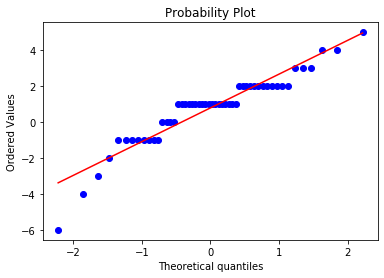

In [12]:
daily_summary = daily_sign_up.pivot(index='application_start_date', columns='Creative',
                    values = 'Company ID').fillna(0)
daily_summary['diff'] = daily_summary['Default Creative'] - daily_summary['Alternative Creative']
stats.probplot(daily_summary['diff'], plot= plt)

In [13]:
w, p = stats.shapiro(daily_summary['diff'])
print('W: {}, p: {}'.format(w,p))

W: 0.9088274836540222, p: 0.0007416366133838892


Since the sample p-value is very low, this indicates that it is likely that the sample came from a population without a normal distribution (accept alternative hypothesis)

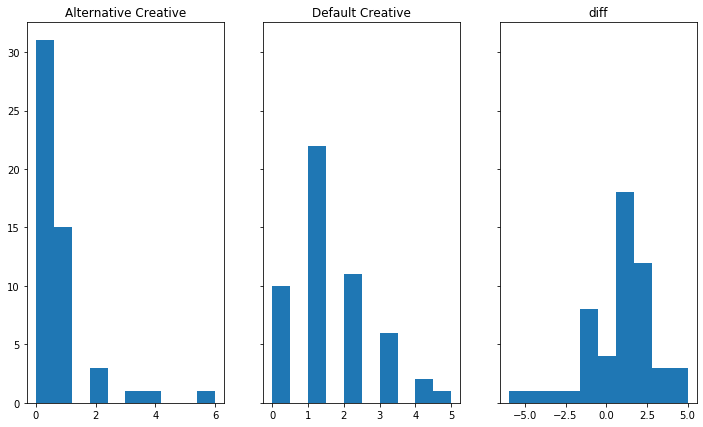

In [14]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel() 
for x in range(3):
    ax[x].hist(daily_summary.iloc[:,x])
    ax[x].set_title(daily_summary.columns[x])


### Wilcoxon test (non parametric equiv for t-test)
The distribution of average sign ups per day is not normally distributed so use non-parametric testing - Wilcoxon test instead of T test.

H0: There is no difference between the median daily sign up for the creatives used.

H1: There is a difference in the median daily sign up for each creative.

In [15]:
stats.wilcoxon(daily_summary['diff'])

WilcoxonResult(statistic=275.5, pvalue=0.0010486871479679805)

There is a statistically significant difference in the median daily sign ups due to creative type

In [16]:
stats.wilcoxon(daily_summary['Default Creative'], daily_summary['Alternative Creative'])

WilcoxonResult(statistic=275.5, pvalue=0.0010486871479679805)

#### Unpaired t-test

In [17]:
#H0: There is no difference between number of signups per day and the Creative used in marketing
#H1: There is a difference between number of signups per day and the Creatuve used in marketing

import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind

t,p, DF = ttest_ind(default['Company ID'], alternative_creative['Company ID'])
print('t-value is {}\n p-value is {} \n degrees of freedom used {}'.format(t,p,DF))

t-value is 0.5586024946693674
 p-value is 0.578477885871228 
 degrees of freedom used 61.0


The p-value, probablity of observing such an extreme value by chance, is not significant at the 0.1, 0.05 or 0.01 level. We have failed to reject the null hypothesis, there is no significant difference in the daily number of signups and the Creative used for email marketing.

### Testing wether the advertising campaign had any effect on the people who have already applied for a loan and those who have not

Looking at the number of people in the campaigns population who have applied already and applied already, there is a large proportion of people who had already started an application, especially within the Alternative Creative group. Due to small number of people, testing for significance on probability of campaign causing customers to finish their application

In [18]:
def f(row):
    if row['application_start_date'] >= row['Email Sent Date']:
        val = 0
    elif row['application_start_date'] < row['Email Sent Date']:
        val = 1
    else:
        val =2
    return val
ca_2 = campaign_applications.dropna(subset=['application_start_date'])
ca_2['already_applied'] = ca_2.apply(f, axis=1)
ca_2_summary = ca_2.groupby(['Creative', 'already_applied']).agg({'Company ID':'count'}).reset_index()
ca_2_summary.pivot(index='already_applied', columns='Creative', values='Company ID')

/Users/Xinny/PycharmProjects/funding_circle_analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Creative,Alternative Creative,Default Creative
already_applied,,
0,28,68
1,6,7
